In [1]:
import os
import sys
import glob
import json
import random
import math
import re
import time
import tqdm
import pickle
import imgaug
import skimage.io
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

sys.path.append("../..")
from extractor.segmentation.Mask_RCNN.mrcnn.config import Config
from extractor.segmentation.Mask_RCNN.mrcnn import utils
import extractor.segmentation.Mask_RCNN.mrcnn.model as modellib
from extractor.segmentation.Mask_RCNN.mrcnn import visualize
from extractor.segmentation.Mask_RCNN.mrcnn.model import log

from extractor.segmentation.configs import PVConfig, PVConfigIR, PVConfigRGB

# Bugfix taken from: https://github.com/tensorflow/tensorflow/issues/24828#issuecomment-464910864
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.


### Load Config

In [2]:
# Comment out the corresponding line below for training Mask R-CNN on IR images or RGB (visual) images 
#config_class = PVConfigIR
config_class = PVConfigRGB
config = config_class()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_MODEL_PATH                /pvextractor/extractor/segmentation/Mask_RCNN/mask_rcnn_coco.h5
COMPUTE_BACKBONE_SHAPE         None
DATASET_MODE                   rgb
DATASET_TRAIN_PATH             /pv_segmentation_dataset/train
DATASET_VAL_PATH               /pv_segmentation_dataset/val
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM      

### Utility Functions

In [3]:
def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
    return frame

### Create Dataset

In [4]:
class PVDataset(utils.Dataset):

    def load_data(self, root_path, use_truncated_modules, mode):
        """Load a subset of the PV segmentation dataset.
        root_path: Root directory of the dataset.
        use_truncated_modules: If False exclude all PV modules not fully visible in frame.
        mode: "ir" or "rgb" to train on monochrome 16-bit IR images or 8-bit visual RGB images.
        """
        self.mode = mode
        self.add_class("pv_module", 1, "pv_module")
        annotation_files = glob.glob(os.path.join(root_path, "annotations", "*.json"))
        
        if mode == "ir":
            file_ext = "tiff"
        elif mode == "rgb":
            file_ext = "jpg"
        else:
            raise ValueError(f"Unknown mode {mode}")

        for annotation_file in tqdm.tqdm(annotation_files):
            with open(annotation_file) as f:
                annotation = json.load(f)
                
            image_name = str.split(os.path.basename(annotation["image"]), ".")[0]
            image_path = os.path.join(root_path, "images_radiometric", "{}.{}".format(image_name, file_ext))
            image = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)  # load to probe shape
            
            try:
                pv_modules = annotation["pv_modules"]
            except KeyError:
                pv_modules = annotation["grid_cells"]
            
            self.add_image("pv_module",
                        image_id=str.split(annotation["image"], ".")[0],
                        path=image_path,
                        width=image.shape[1],
                        height=image.shape[0],
                        use_truncated_modules=use_truncated_modules,
                        pv_modules=pv_modules)

    def create_masks(self, pv_modules, img_width, img_height, use_truncated_modules):
        masks = []
        for module in pv_modules:
            if not use_truncated_modules and module["truncated"]:
                continue
            mask = np.zeros((img_height, img_width), dtype=np.float32)
            pts = np.array([(round(c["x"]), round(c["y"])) for c in module["corners"]])
            mask = cv2.fillConvexPoly(mask, pts, color=(255, 255, 255))
            masks.append(mask)
        if len(masks) > 0:
            masks = np.stack(masks, axis=2)
        else:
            masks = np.zeros((img_height, img_width, 1), dtype=np.float32)
        return masks
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        Preprocessing is applied.
        """
        if self.mode == "ir":
            image = cv2.imread(self.image_info[image_id]['path'], cv2.IMREAD_ANYDEPTH)
            image = preprocess_radiometric_frame(image)
            image = np.stack((image, image, image), axis=2) # make 3-channel image
        elif self.mode == "rgb":
            image = cv2.imread(self.image_info[image_id]['path'], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # test if image is valid
        info = self.image_info[image_id]
        assert isinstance(image, np.ndarray)
        assert image.shape == (info["height"], info["width"], 3)
        assert image.dtype == np.uint8
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        pv_modules = info["pv_modules"]
        masks = self.create_masks(pv_modules, info["width"], info["height"], info["use_truncated_modules"])
        return masks.astype(np.bool), np.ones([masks.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "pv_module":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
# Training dataset
dataset_train = PVDataset()
dataset_train.load_data(
    root_path=config.DATASET_TRAIN_PATH,
    use_truncated_modules=config.USE_TRUNCATED_MODULES,
    mode=config.DATASET_MODE)
dataset_train.prepare()

# Validation dataset
dataset_val = PVDataset()
dataset_val.load_data(
    root_path=config.DATASET_VAL_PATH,
    use_truncated_modules=config.USE_TRUNCATED_MODULES,
    mode=config.DATASET_MODE)
dataset_val.prepare()

config.STEPS_PER_EPOCH = dataset_train.num_images
config.VALIDATION_STEPS = dataset_val.num_images

100%|██████████| 16/16 [00:01<00:00, 14.84it/s]


### Visualize Dataset

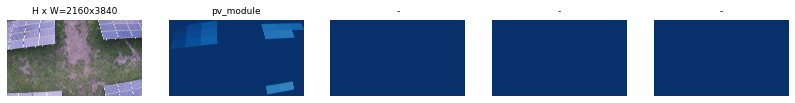

(2160, 3840, 3) (2160, 3840, 16)


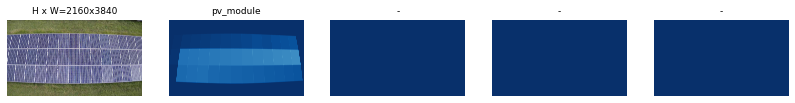

(2160, 3840, 3) (2160, 3840, 38)


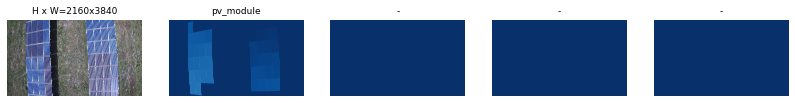

(2160, 3840, 3) (2160, 3840, 39)


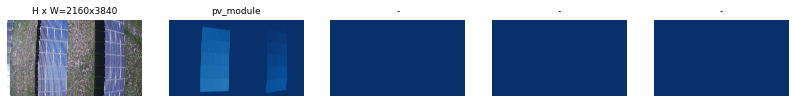

(2160, 3840, 3) (2160, 3840, 42)


In [6]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    print(image.shape, mask.shape)

### Train Model

#### Load weights

In [7]:
def init_model(model, weights):
    """Initialize models from pretrained weights.
    Pass any of "imagenet", "coco", "last" or path to *.h5 weights file
    into the `weights` argument.
    """
    if weights == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
        print("Loaded imagenet pretrained weights.")
    elif weights == "coco":
        model.load_weights(config.COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
        print("Loaded COCO pretrained weights.")
    elif weights == "last":
        model.load_weights(model.find_last(), by_name=True)
        print("Loaded weigths from {}".format(model.find_last()))
    else:
        model.load_weights(weights, by_name=True)
        print("Loaded weigths from {}".format(weights))
    return model

#### Data augmentation

In [8]:
train_augmenter = imgaug.augmenters.Sequential([
    #imgaug.augmenters.Affine(rotate=[-90, 0, 0, 90], fit_output=True),  try without this augmentation
    imgaug.augmenters.Fliplr(0.5),
    #imgaug.augmenters.Flipud(0.5),
    imgaug.augmenters.Sometimes(0.5,
      imgaug.augmenters.KeepSizeByResize(
        imgaug.augmenters.Affine(rotate=(-10, 10), fit_output=True)
      ),
    )
])

#### Train Mask R-CNN head

In [9]:
num_epochs_head = 30 #60

In [10]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=config.MODEL_DIR)
model = init_model(model, weights="coco")

history_pretrain = model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=num_epochs_head,
            layers="heads",
            augmentation=train_augmenter)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead




Loaded COCO pretrained weights.

Starting at epoch 0. LR=0.001

Checkpoint Path: /pvextractor/extractor/segmentation/Mask_RCNN/logs/pv_modules20220912T1453/mask_rcnn_pv_modules_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_b

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/30
64/65 [============================>.] - ETA: 5s - loss: 2.8058 - rpn_class_loss: 0.5090 - rpn_bbox_loss: 0.7211 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.7079 - mrcnn_mask_loss: 0.5664 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


65/65 [==============================] - 501s 8s/step - loss: 2.7930 - rpn_class_loss: 0.5035 - rpn_bbox_loss: 0.7181 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.7042 - mrcnn_mask_loss: 0.5638 - val_loss: 1.7234 - val_rpn_class_loss: 0.1273 - val_rpn_bbox_loss: 0.3586 - val_mrcnn_class_loss: 0.3458 - val_mrcnn_bbox_loss: 0.4669 - val_mrcnn_mask_loss: 0.4248

Epoch 2/30
65/65 [==============================] - 246s 4s/step - loss: 1.7159 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.4159 - mrcnn_class_loss: 0.3623 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.3466 - val_loss: 1.3800 - val_rpn_class_loss: 0.0916 - val_rpn_bbox_loss: 0.3146 - val_mrcnn_class_loss: 0.3532 - val_mrcnn_bbox_loss: 0.3614 - val_mrcnn_mask_loss: 0.2592
Epoch 3/30
65/65 [==============================] - 372s 6s/step - loss: 1.3684 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.3310 - mrcnn_bbox_loss: 0.3590 - mrcnn_mask_loss: 0.2404 - val_loss: 1.1459 - val_rpn_class_loss: 0.0788 - va

#### Fine tune all layers

In [ ]:
num_epochs_finetune = 30 #60

model = modellib.MaskRCNN(mode="training", config=config, model_dir=config.MODEL_DIR)
#model = init_model(model, weights="last")
#model = init_model(model, weights=os.path.join(config.MODEL_DIR, "pv_modules20210521T1611", "mask_rcnn_pv_modules_0060.h5"))  # ir
model = init_model(model, weights=os.path.join(config.MODEL_DIR, "pv_modules20220912T1453", "mask_rcnn_pv_modules_0030.h5"))

history_finetune = model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=num_epochs_head+num_epochs_finetune,
            layers="all",
            augmentation=train_augmenter)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead




Re-starting from epoch 30
Loaded weigths from /pvextractor/extractor/segmentation/Mask_RCNN/logs/pv_modules20220912T1453/mask_rcnn_pv_modules_0030.h5

Starting at epoch 30. LR=0.0001

Checkpoint Path: /pvextractor/extractor/segmentation/Mask_RCNN/logs/pv_modules20220912T1453/mask_rcnn_pv_modules_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 31/60
60/65 [==========================>...] - ETA: 17s - loss: 0.3537 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0822

### Compute validation metric

In [9]:
class InferenceConfig(config_class):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5

inference_config = InferenceConfig()

In [10]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=config.MODEL_DIR)
#model = init_model(model, weights="last")
#model = init_model(model, weights=os.path.join(config.MODEL_DIR, "pv_modules20210521T1611", "mask_rcnn_pv_modules_0120.h5"))  # ir
model = init_model(model, weights=os.path.join(config.MODEL_DIR, "pv_modules20220912T1453", "mask_rcnn_pv_modules_0030.h5"))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.




Re-starting from epoch 30
Loaded weigths from /pvextractor/extractor/segmentation/Mask_RCNN/logs/pv_modules20220912T1453/mask_rcnn_pv_modules_0030.h5


In [11]:
# Compute VOC-Style mAP at IoU=0.5 / different IoU thresholds
mAPs = []
mF1s = []
for iou_threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    APs = []
    F1s = []
    for image_id in dataset_val.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        results = model.detect([image], verbose=0)
        r = results[0]
        AP, precisions, recalls, f1scores, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold)
        if len(f1scores) > 0:  # do not consider examples without any annotation
            F1s.append(f1scores[-1])  # we care only about the f1 score at the last prediction step
            APs.append(AP)
    mAPs.append(np.mean(APs))
    mF1s.append(np.mean(F1s))
    print("IoU threshold: {}, mAP: {}, mF1: {}".format(iou_threshold, np.mean(APs), np.mean(F1s)))
print("mmAP: {}, mmF1: {}".format(np.mean(mAPs), np.mean(mF1s)))


IoU threshold: 0.5, mAP: 0.97814605226807, mF1: 0.9402641938987528
IoU threshold: 0.55, mAP: 0.97814605226807, mF1: 0.9402641938987528
IoU threshold: 0.6, mAP: 0.97814605226807, mF1: 0.9402641938987528
IoU threshold: 0.65, mAP: 0.97814605226807, mF1: 0.9402641938987528
IoU threshold: 0.7, mAP: 0.97814605226807, mF1: 0.9402641938987528
IoU threshold: 0.75, mAP: 0.9755598442946096, mF1: 0.9382150130482821
IoU threshold: 0.8, mAP: 0.9755598442946096, mF1: 0.9382150130482821
IoU threshold: 0.85, mAP: 0.9554019812257053, mF1: 0.9252739947297854
IoU threshold: 0.9, mAP: 0.8362636923481597, mF1: 0.8409560888938918
IoU threshold: 0.95, mAP: 0.12531362760391462, mF1: 0.22358806625195216
mmAP: 0.8758829251107348, mmF1: 0.8567569145465959


### Test model on validation images

In [12]:
mode = "all"  # "all" / "random"

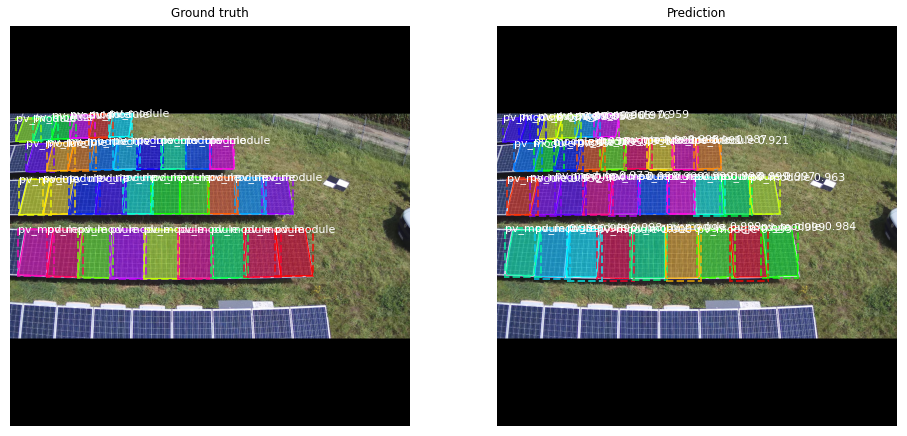

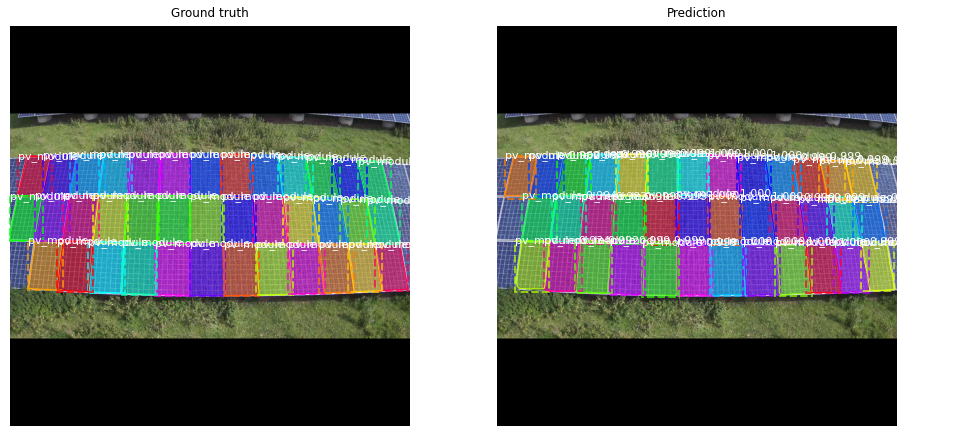

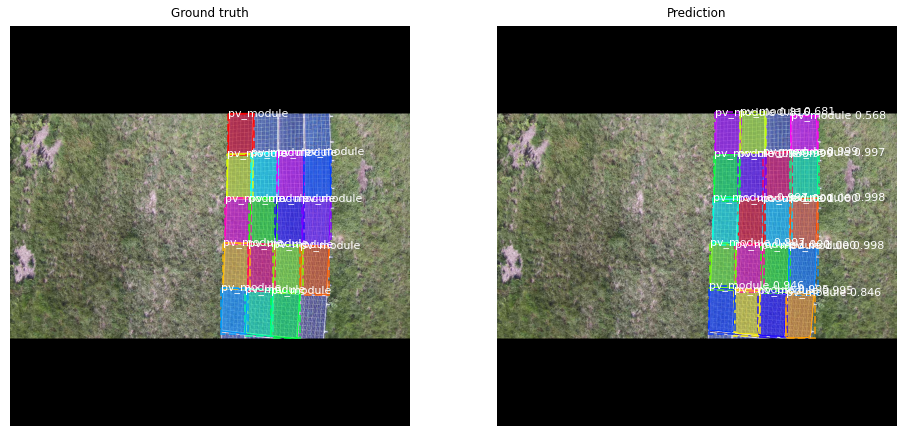

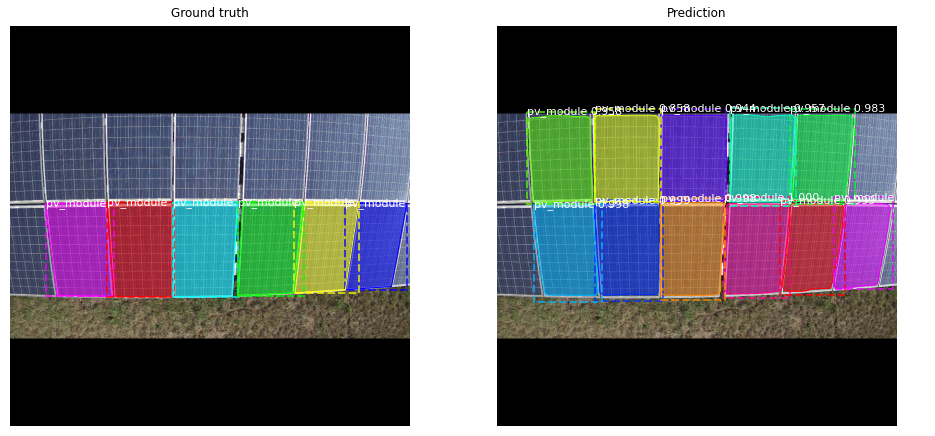

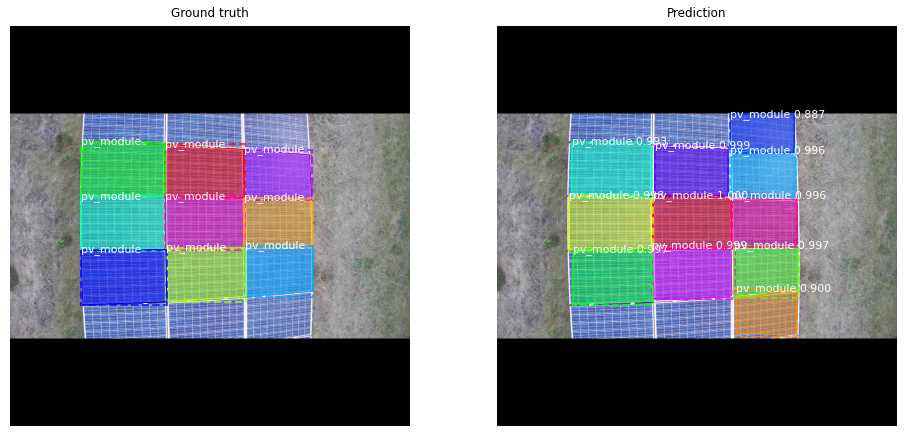

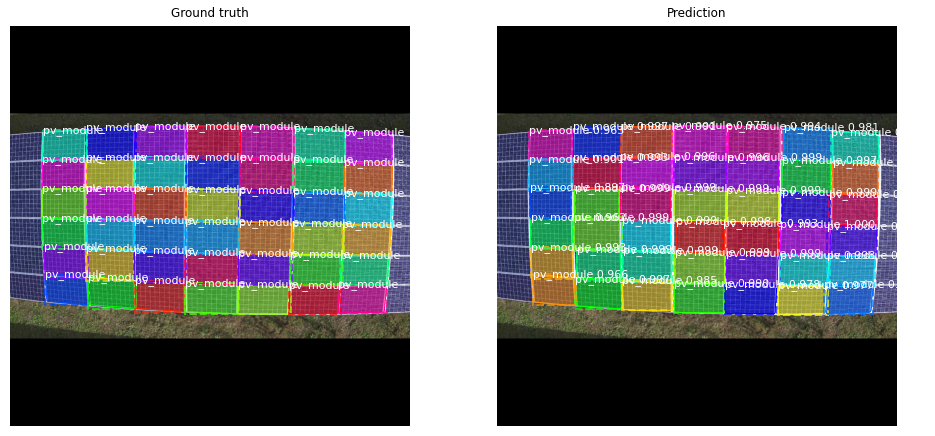

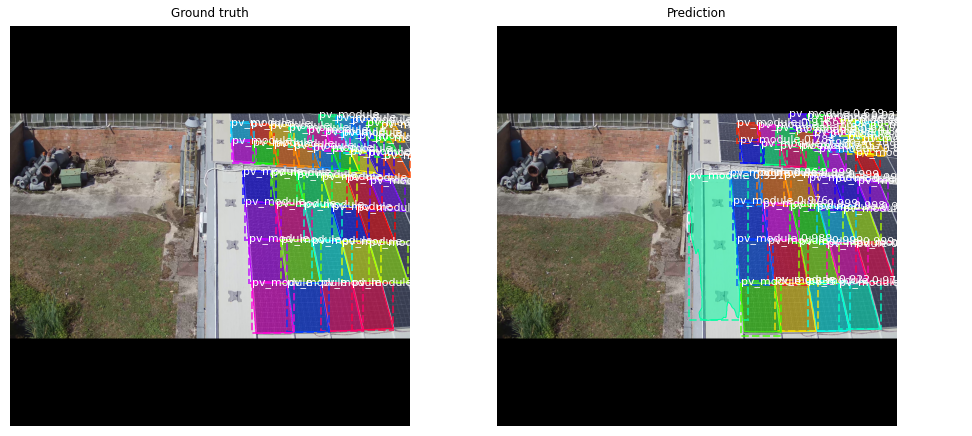

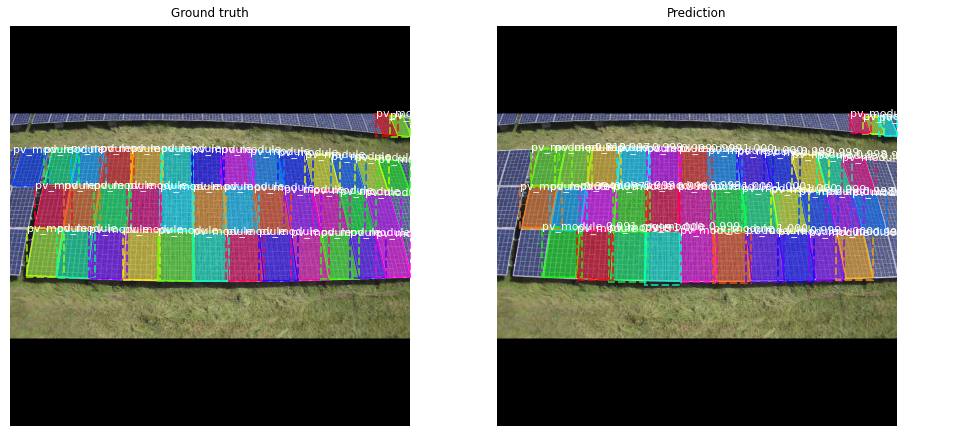

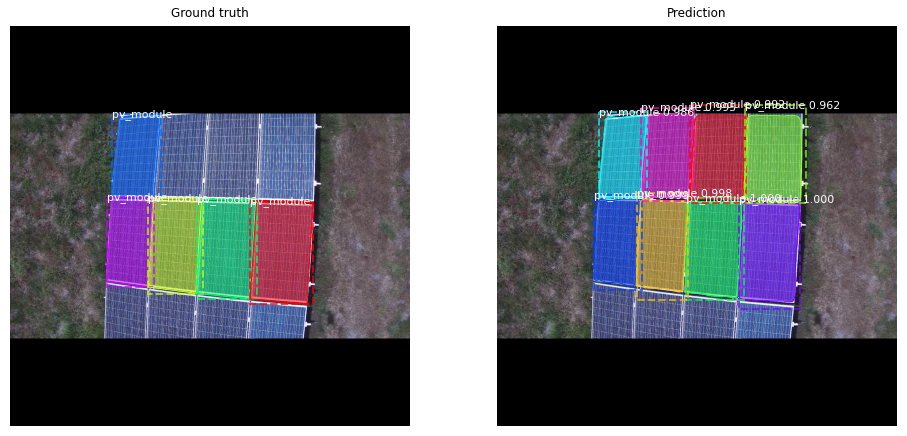

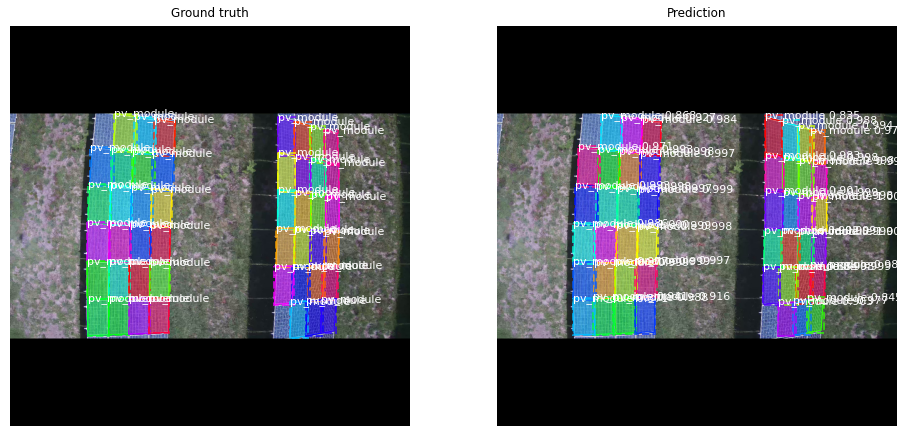

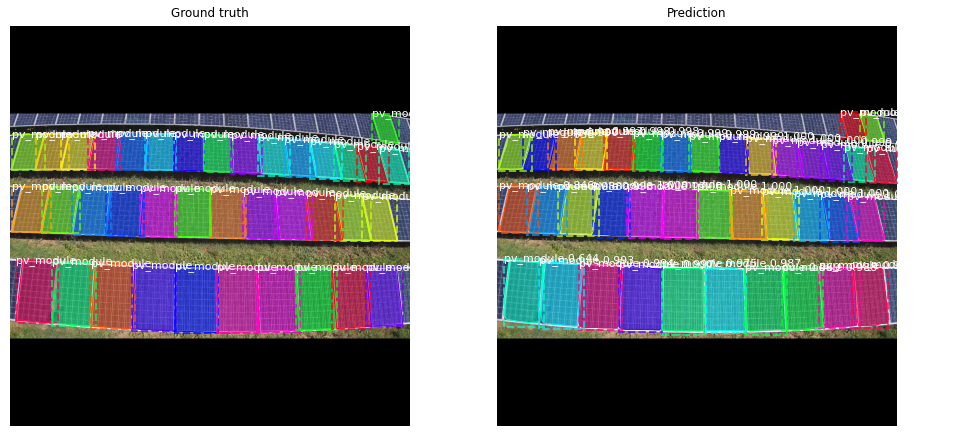

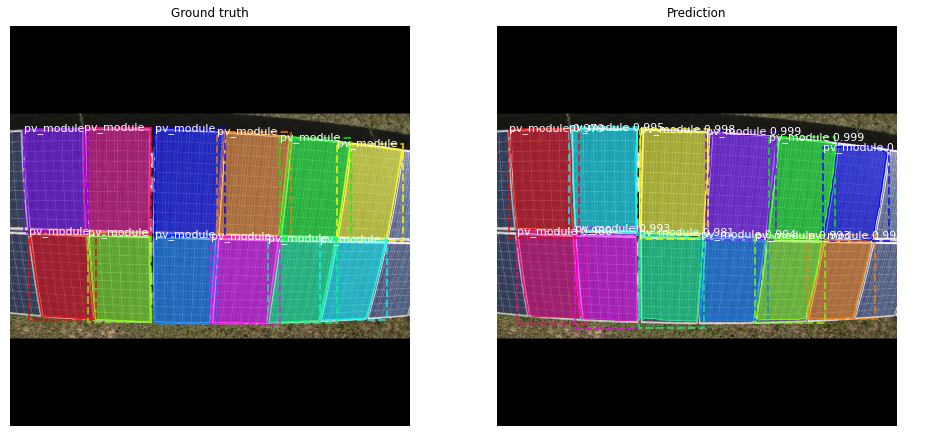

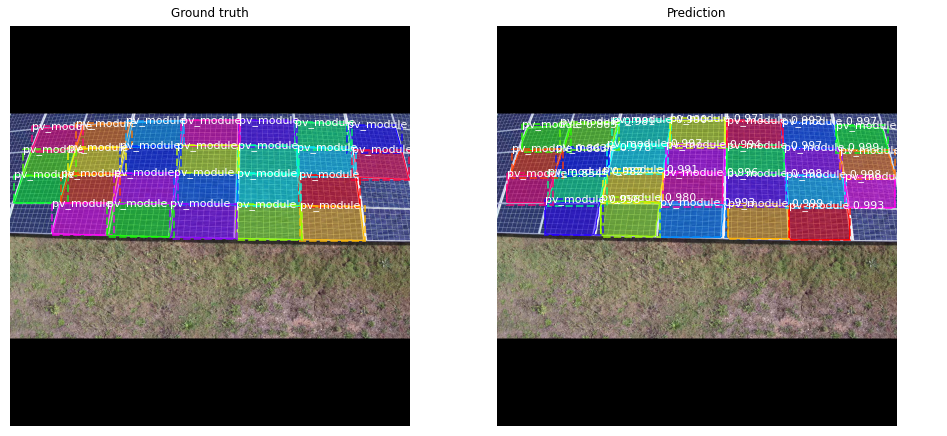

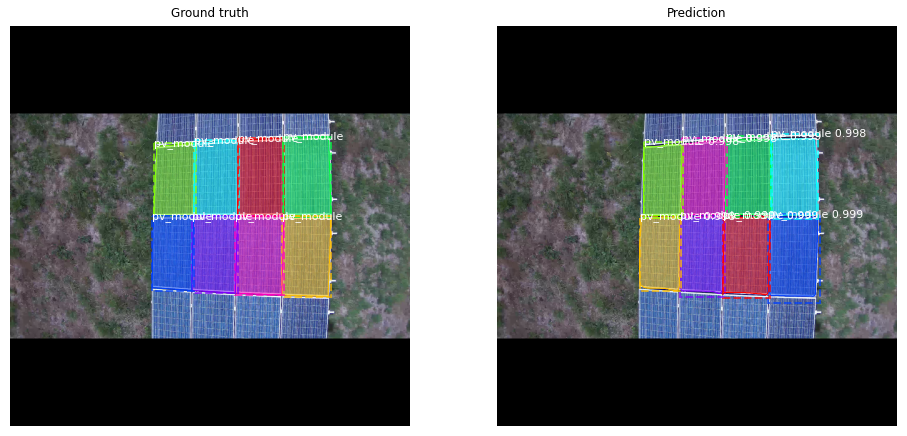

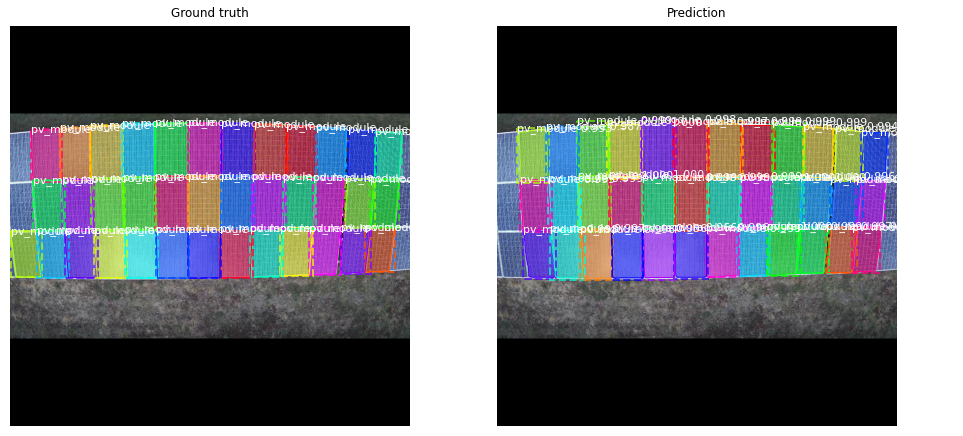

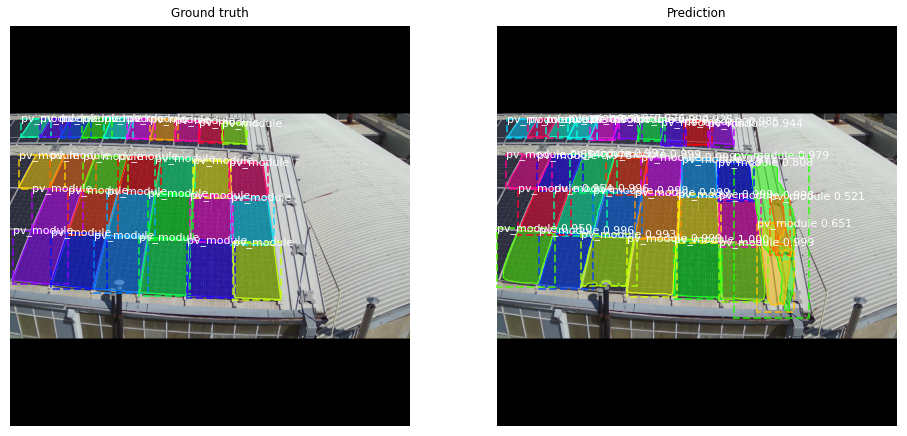

In [13]:
def display(logging=True):
    if logging:
        log("original_image", original_image)
        log("image_meta", image_meta)
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    # ground truth
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, ax=ax1)
    # prediction
    results = model.detect([original_image], verbose=bool(logging))
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=ax2)
    
    ax1.set_title("Ground truth")
    ax2.set_title("Prediction")
    plt.show()
    

if mode == "random":
    image_id = random.choice(dataset_val.image_ids)
    print(dataset_val.source_image_link(image_id))
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    display()

elif mode == "all":
    for image_id in dataset_val.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                                   image_id, use_mini_mask=False)
        display(logging=False)